# CME 193 Spring 2018
## Lecture 7 Supplement


# Face Classification Example 
## Goal: 

### Train a classifer to predict the names of 7 famous politicans from images of their faces. 

In [1]:
from time import time
import numpy as np
%matplotlib inline

import matplotlib.pyplot as plt
import logging
from sklearn.datasets import fetch_lfw_people


logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)
logging.getLogger("requests").setLevel(logging.WARNING)

# Loading The Data 

In [2]:
# Loading the dataset
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# loading the x
X = lfw_people.data
n_samples, n_features = X.shape

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

logging.info("Names to predict {} ".format(target_names))
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

INFO:Names to predict ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair'] 


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


## Inspect size of each image

In [3]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
print("height: %d pixels" % h)
print("width: %d pixels" % w)

height: 50 pixels
width: 37 pixels


## Helper Function To Plot Data

In [4]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


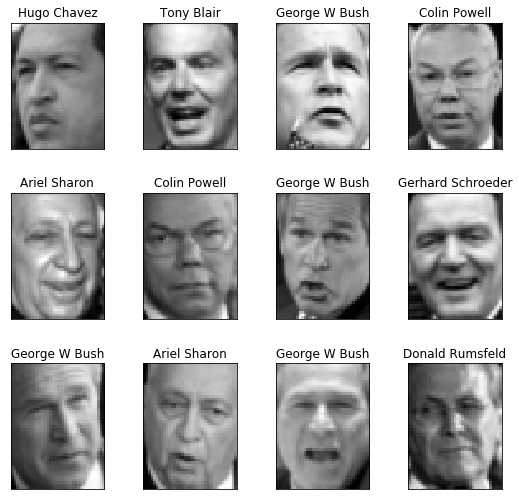

In [5]:
plot_gallery(X, target_names[y], h, w)

### Split Data into Training and Testing sets

In [6]:
### First step is to split the set into training and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

logging.info("Testing size is {}".format(X_train.shape))

INFO:Testing size is (966, 1850)


# Dimensionality Reduction 
1) Now since the dimensionality of our input is large (WxH). We use PCA to extract the top principal components of the images. 

2) PCA is a powerful and widely used linear technique in statistics, signal processing, image processing, and elsewhere. 

3) In statistics, PCA is a method for simplifying a multidimensional dataset to lower dimensions for analysis, visualization or data compression. 

4) PCA represents the data in a new coordinate system in which basis vectors follow modes of greatest variance in the data.
 
5) Consider a 50 X 50 Image: We store the image in a long 1-D row vector by concatenating image pixels column by column (or alternatively row by row), i.e 50 x 50 = 2500 size vector (The huge number 2500 is the dimensionality of our vector space). 
        


In [7]:
from sklearn.decomposition import PCA

# Define the number of components
n_components = 150
#Extract the top principal components
logging.info("Extracting the top {} eigenfaces from {} faces".format(n_components, X_train.shape[0]))
t0 = time()

# fit the PCA object
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
logging.info("done in {} seconds".format(time() - t0))

# reshape for plotting purposes
logging.info("Pricipal Axes in feature space: {}".format(pca.components_.shape))
eigenfaces = pca.components_.reshape((n_components, h, w))

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]

INFO:Extracting the top 150 eigenfaces from 966 faces
INFO:done in 0.11207818984985352 seconds
INFO:Pricipal Axes in feature space: (150, 1850)


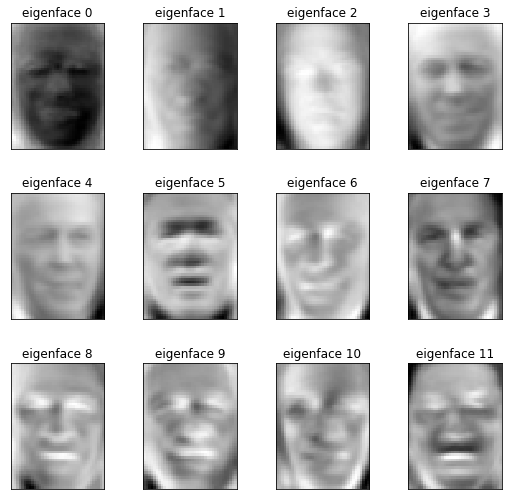

In [8]:
plot_gallery(eigenfaces, eigenface_titles, h, w)

#### Now lets reduce the dimensionality of our dataset by applying the transform
X_train_pca is now shape= (n_samples, n_components)

In [10]:
logging.info("Projectin`g the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
logging.info("done in %0.3fs" % (time() - t0))

INFO:Projectin`g the input data on the eigenfaces orthonormal basis
INFO:done in 0.010s


In [11]:
print(X_train.shape)
X_train_pca.shape

(966, 1850)


(966, 150)

### PCA Reconstruction
Let's see how our faces look uses just the first n_components principal components to reconstruct the data set
this is done by by multiplying X_train_pca (n_samples, n_componeents) with pca.components_ (n_components, n_features)
    
pca.components_: is the principal axes in the feature space, representing the directions of maximum variance in the data. The components are sorted by the percentage of the variance they explaine 

(966, 1850)


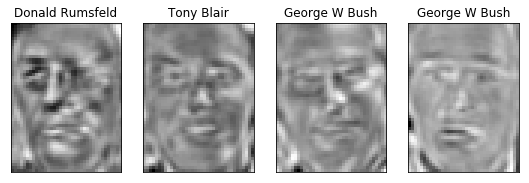

In [14]:
X_train_reconstructed = np.dot(X_train_pca, pca.components_)
plot_gallery(X_train_reconstructed, target_names[y_train], h, w, n_row=1)

# Training a Classifier

Here we are using a Support Vector Classifier to classify the dataset (Multiclass classification) and grid searching over the hyperparameters C and gamma:

The constant C > 0 sets the relative importance of maximizing the margin. In other words, the C parameter trades off misclassification of training examples against simplicity of the decision surface. A low C makes the decision surface smooth, while a high C aims at classifying all training examples correctly by giving the model freedom to select more samples as support vectors.

The gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors. 


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1, 10, 100],
              'gamma': [0.0001, 0.001, 0.01, 0.1]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, n_jobs=2)
clf = clf.fit(X_train_pca, y_train)

print(("done in %0.3fs" % (time() - t0)))
print("Best estimator found by grid search:")
print((clf.best_estimator_))

Fitting the classifier to the training set
done in 4.558s
Best estimator found by grid search:
SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


# Examining the test set performance

In [16]:
print("Predicting people's names on the test set")
t0 = time()

# Find the prediction
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

# Qualitative performance
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

Predicting people's names on the test set
done in 0.040s


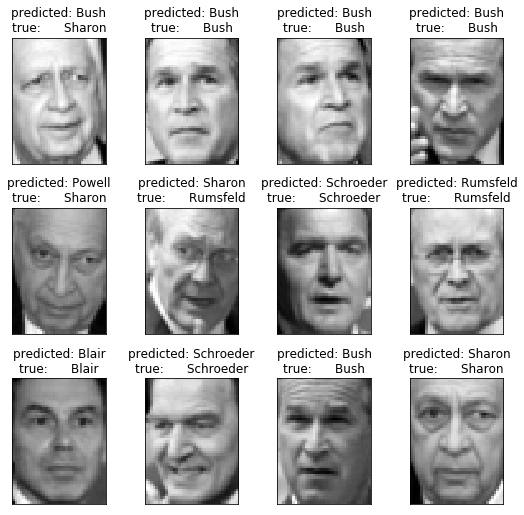

In [17]:
plot_gallery(X_test, prediction_titles, h, w)

# Quantitative Evalutaion 

Seeing the results of the model are nice, but we need to break down its performance more rigorously. The cell below uses sklearn's classification report function to generate the precision, recall, f1-score, and support of the names evaluate 

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.80      0.70      0.74        23
     Colin Powell       0.76      0.95      0.84        60
  Donald Rumsfeld       0.92      0.81      0.86        27
    George W Bush       0.93      0.88      0.91       137
Gerhard Schroeder       0.89      0.83      0.86        29
      Hugo Chavez       0.68      0.87      0.76        15
       Tony Blair       0.81      0.71      0.76        31

      avg / total       0.86      0.85      0.85       322



In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=list(range(n_classes)))
print(cm)

[[ 16   3   1   1   0   1   1]
 [  0  57   0   0   0   1   2]
 [  1   2  22   1   0   0   1]
 [  3   8   1 121   0   3   1]
 [  0   2   0   2  24   1   0]
 [  0   0   0   1   1  13   0]
 [  0   3   0   4   2   0  22]]


In [54]:
# Now lets plot this

In [20]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(list(range(cm.shape[0])), list(range(cm.shape[1]))):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 16   3   1   1   0   1   1]
 [  0  57   0   0   0   1   2]
 [  1   2  22   1   0   0   1]
 [  3   8   1 121   0   3   1]
 [  0   2   0   2  24   1   0]
 [  0   0   0   1   1  13   0]
 [  0   3   0   4   2   0  22]]


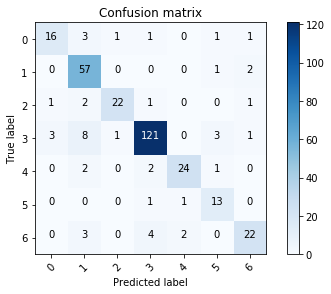

In [21]:
plot_confusion_matrix(cm, list(range(n_classes)))

## Attribution

This notebook is based on the Jupyter Notebook lecture from https://github.com/ogrisel/notebooks